In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [32]:
%cd "/content/drive/MyDrive/Colab Notebooks/DSPG Models/gutter_quality_model"

/content/drive/MyDrive/Colab Notebooks/DSPG Models/gutter_quality_model


#Creating the Dataset

In [33]:
data_dir = os.getcwd()+'/data'

### Define the attribute of the images and batch size

In [34]:
batch_size = 32
img_height = 180
img_width = 180

In [35]:
all_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 175 files belonging to 2 classes.


In [36]:
len(all_data)

6

In [37]:
#70% testing 20% validation 10% testing
train_size = int(len(all_data)*.7)
val_size = int(len(all_data)*.2)
test_size = int(len(all_data)-train_size-val_size)

In [38]:
print(train_size)
print(val_size)
print(test_size)

train_size+val_size+test_size


4
1
1


6

In [39]:
train = all_data.take(train_size)
val = all_data.skip(train_size).take(val_size)
test = all_data.skip(train_size+val_size).take(test_size)

In [40]:
class_names = all_data.class_names
print(class_names)

['damaged_gutter', 'good_gutter']


#Display some of the images

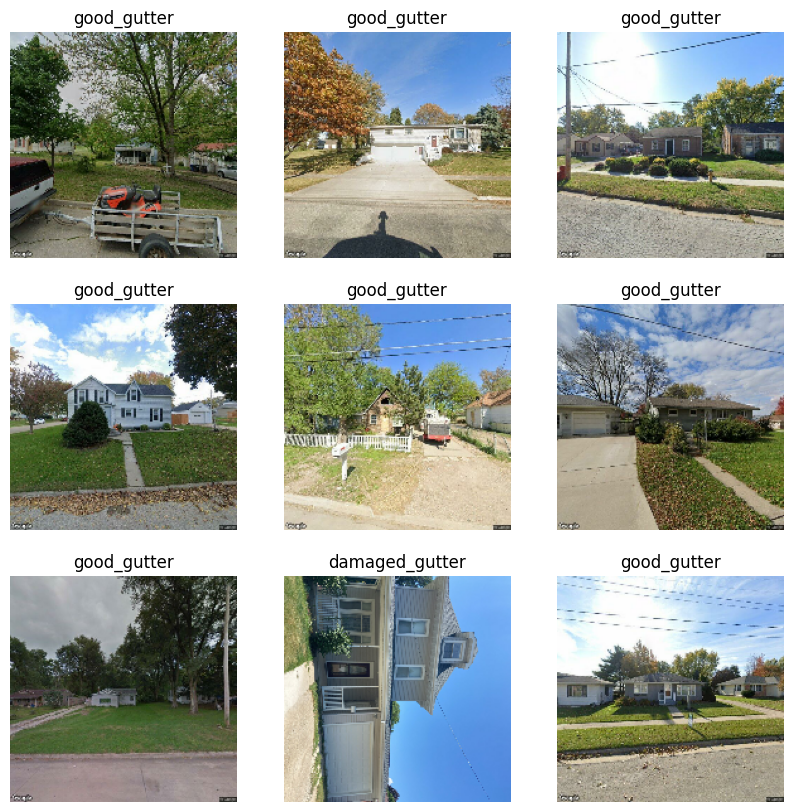

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in all_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)

## Model Structure

In [44]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [47]:
epochs=10
with tf.device('/device:GPU:0'):
  history = model.fit(
    train,
    validation_data=val,
    epochs=epochs)

Epoch 1/10
4/4 [==============================] - 17s 961ms/step - loss: 1.5169 - accuracy: 0.5000 - val_loss: 1.0138 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 452ms/step - loss: 0.8337 - accuracy: 0.6406 - val_loss: 0.5989 - val_accuracy: 0.6562
Epoch 3/10
4/4 [==============================] - 2s 453ms/step - loss: 0.6130 - accuracy: 0.7266 - val_loss: 0.5943 - val_accuracy: 0.9688
Epoch 4/10
4/4 [==============================] - 2s 453ms/step - loss: 0.5631 - accuracy: 0.7969 - val_loss: 0.4785 - val_accuracy: 0.6562
Epoch 5/10
4/4 [==============================] - 2s 398ms/step - loss: 0.4835 - accuracy: 0.7734 - val_loss: 0.4512 - val_accuracy: 0.6562
Epoch 6/10
4/4 [==============================] - 5s 885ms/step - loss: 0.5110 - accuracy: 0.7188 - val_loss: 0.6680 - val_accuracy: 0.5938
Epoch 7/10
4/4 [==============================] - 2s 451ms/step - loss: 0.6085 - accuracy: 0.6719 - val_loss: 0.4024 - val_accuracy: 0.9062
Epoch 8/10
4/4 [===

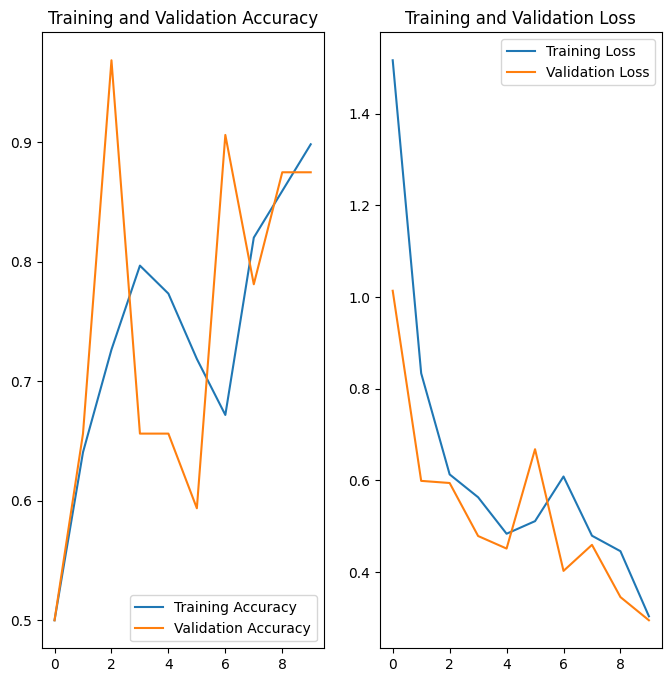

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [50]:
pre = Precision()
re = Recall()
#acc = BinaryAccuracy()
acc = Accuracy()

In [51]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    #New Line

    yhat = np.array(tf.math.argmax(yhat,axis=1))
    print(y)
    print(yhat)

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 281ms/step
[0 1 0 1 1 1 0 0 1 1 1 1 0 1 1]
[0 1 0 1 1 1 0 1 1 0 1 1 0 1 1]


In [52]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8999999761581421, Recall:0.8999999761581421, Accuracy:0.8666666746139526


117948/117948 [==============================] - 0s 0us/step


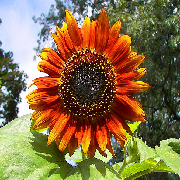

1/1 [==============================] - 0s 329ms/step
This image most likely belongs to good_gutter with a 72.29 percent confidence.


In [53]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
tf.keras.preprocessing.image.array_to_img(img_array).show()
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [56]:
model.save(os.path.join('models','gutter_quality_model.h5'))